In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogFormatter
import pickle
import os
import numpy as np

## Xeon Platinum 8175M Single Core Peak GFLOP/s

In [2]:
AVX512_FLOPS_PER_CYCLE = 8*2 # DP FMA
NUM_AVX512_UNITS = 2
AVX512_FREQ = 2.4 # All Cores Active AVX512 Boost (GHz)
XEON_8175M_PEAK_FLOPS = AVX512_FREQ * NUM_AVX512_UNITS * AVX512_FLOPS_PER_CYCLE

In [3]:
XEON_8175M_PEAK_FLOPS

76.8

## Xeon Platinum 8175M Single Core Tuned STREAM BW

In [4]:
XEON_8175M_PEAK_BW = 13.5163 # GB/s

## Load FLOP/s of benchmark

In [5]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48
MAT_PATH = "./../../example_mats_med/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])
mat_FLOPS = {}
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_FLOPS[mat_path.split("./../../")[1]] = FLOPS_PER_PANEL

In [6]:
LOG_DIR = "./../../logs/reg_pack/pyfr/"
with open(LOG_DIR+"run_1.dat", "rb") as f:
    run_1 = pickle.load(f)
with open(LOG_DIR+"run_2.dat", "rb") as f:
    run_2 = pickle.load(f)
with open(LOG_DIR+"run_3.dat", "rb") as f:
    run_3 = pickle.load(f)

In [7]:
def calc_GFLOPs(mat_FLOPS, runs, t='best'):
    NUM_PANELS = 192000 / 48

    mat_names = runs[0]['mat_file']
    local_FLOPs = []
    ref_FLOPs = []

    for i, mat_name in enumerate(mat_names):
        FLOPS_PER_PANEL = mat_FLOPS[mat_name]
        local_best = []
        ref_best = []
        for r, run in enumerate(runs):
            time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
            time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS

            local_best.append(FLOPS_PER_PANEL / time_per_panel_local)
            ref_best.append(FLOPS_PER_PANEL / time_per_panel_ref)
        local_avg = sum(local_best) / len(local_best)
        ref_avg = sum(ref_best) / len(ref_best)

        local_FLOPs.append(local_avg / 1e9)
        ref_FLOPs.append(ref_avg / 1e9)

    return mat_names, ref_FLOPs, local_FLOPs

## Load AI of benchmark

In [8]:
import math

def calc_mem_ref_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    return (mem * num_panels)# + mem_A # dont repeat A load

def calc_mem_local_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    # round A up to nearest multiple of 64 (cache line)
    # mem_A = int(math.ceil(mem_A / 64.0)) * 64
    return (mem * num_panels)# + mem_A # dont repeat A load

In [9]:
mat_AI_ref = {}
mat_AI_local = {}
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    REF_MEM_PER_PANEL = calc_mem_ref_beta_0(test_mat)
    LOCAL_MEM_PER_PANEL = calc_mem_local_beta_0(test_mat)

    mat_AI_ref[mat_path.split("./../../")[1]] = FLOPS_PER_PANEL / REF_MEM_PER_PANEL
    mat_AI_local[mat_path.split("./../../")[1]] = FLOPS_PER_PANEL / LOCAL_MEM_PER_PANEL

In [10]:
def get_AI(mat_AI_ref, mat_AI_local, mat_names):
    ref_AIs, local_AIs = [], []
    
    for mat_name in mat_names:
        ref_AIs.append(mat_AI_ref[mat_name])
        local_AIs.append(mat_AI_local[mat_name])
    
    return ref_AIs, local_AIs

# Quad

In [11]:
q_mat_names, q_ref_FLOPs, q_local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1['quad'], run_2['quad'], run_3['quad']])

In [12]:
q_ref_AIs, q_local_AIs = get_AI(mat_AI_ref, mat_AI_local, q_mat_names)

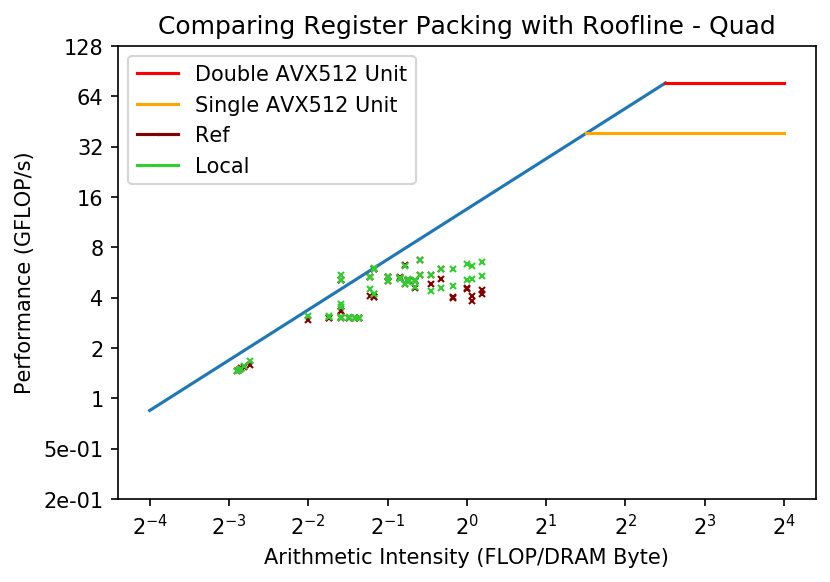

In [13]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='orange', label="Single AVX512 Unit")

ax.plot(q_ref_AIs[0], q_ref_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref")
for i, mat_name in enumerate(q_mat_names):
    ax.plot(q_ref_AIs[i], q_ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(q_local_AIs[0], q_local_FLOPs[0], marker='x', color='limegreen', ms=1, label="Local")
for i, mat_name in enumerate(q_mat_names):
    ax.plot(q_local_AIs[i], q_local_FLOPs[i], marker='x', color='limegreen', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (GFLOP/s)')
ax.set_title('Comparing Register Packing with Roofline - Quad')
plt.legend()
plt.savefig("./../../plots/reg_packing_comp/pyfr/roofline/quad.pdf")
plt.show()

# Hex

In [14]:
h_mat_names, h_ref_FLOPs, h_local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1['hex'], run_2['hex'], run_3['hex']])

In [15]:
h_ref_AIs, h_local_AIs = get_AI(mat_AI_ref, mat_AI_local, h_mat_names)

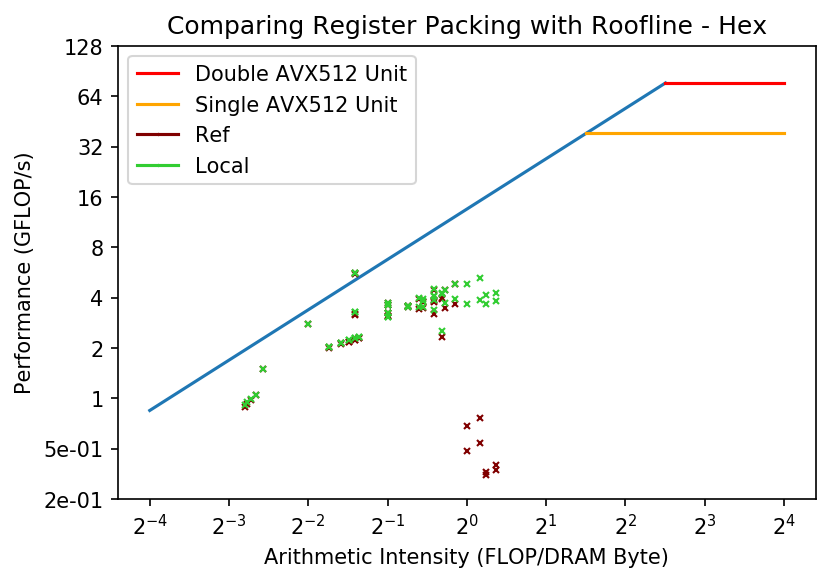

In [16]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='orange', label="Single AVX512 Unit")

ax.plot(h_ref_AIs[0], h_ref_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref")
for i, mat_name in enumerate(h_mat_names):
    ax.plot(h_ref_AIs[i], h_ref_FLOPs[i], marker='x', color='maroon', ms=3)
        
ax.plot(h_local_AIs[0], h_local_FLOPs[0], marker='x', color='limegreen', ms=1, label="Local")
for i, mat_name in enumerate(h_mat_names):
    ax.plot(h_local_AIs[i], h_local_FLOPs[i], marker='x', color='limegreen', ms=3)


ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (GFLOP/s)')
ax.set_title('Comparing Register Packing with Roofline - Hex')
plt.legend()
plt.savefig("./../../plots/reg_packing_comp/pyfr/roofline/hex.pdf")
plt.show()

# Tet

In [17]:
te_mat_names, te_ref_FLOPs, te_local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1['tet'], run_2['tet'], run_3['tet']])

In [18]:
te_ref_AIs, te_local_AIs = get_AI(mat_AI_ref, mat_AI_local, te_mat_names)

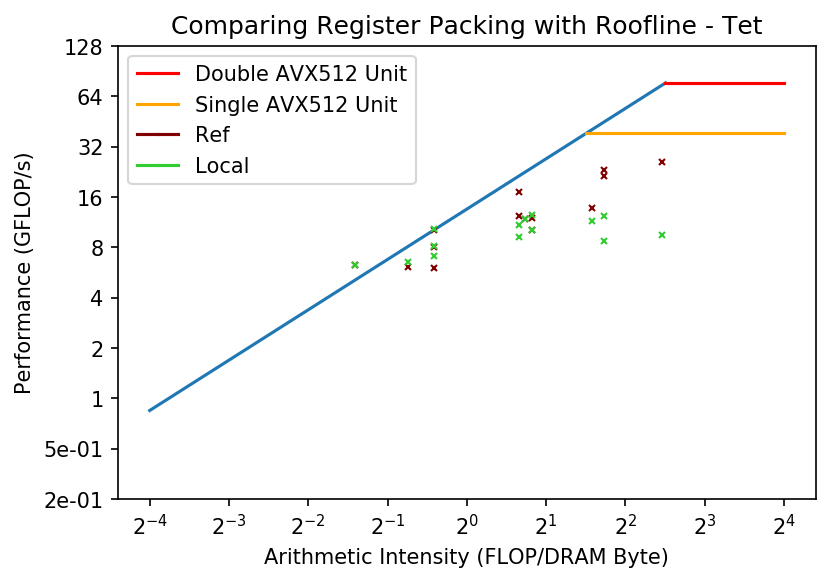

In [19]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='orange', label="Single AVX512 Unit")

ax.plot(te_ref_AIs[0], te_ref_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref")
for i, mat_name in enumerate(te_mat_names):
    ax.plot(te_ref_AIs[i], te_ref_FLOPs[i], marker='x', color='maroon', ms=3)
ax.plot(te_local_AIs[0], te_local_FLOPs[0], marker='x', color='limegreen', ms=1, label="Local")
for i, mat_name in enumerate(te_mat_names):
    ax.plot(te_local_AIs[i], te_local_FLOPs[i], marker='x', color='limegreen', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (GFLOP/s)')
ax.set_title('Comparing Register Packing with Roofline - Tet')
plt.legend()
plt.savefig("./../../plots/reg_packing_comp/pyfr/roofline/tet.pdf")
plt.show()

# Tri

In [20]:
tr_mat_names, tr_ref_FLOPs, tr_local_FLOPs = calc_GFLOPs(mat_FLOPS, [run_1['tri'], run_2['tri'], run_3['tri']])

In [21]:
tr_ref_AIs, tr_local_AIs = get_AI(mat_AI_ref, mat_AI_local, tr_mat_names)

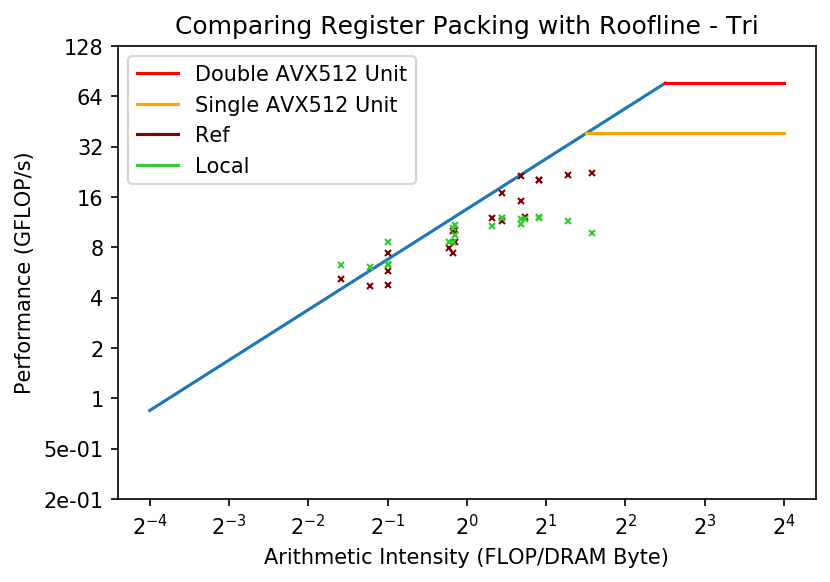

In [22]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
y = x*XEON_8175M_PEAK_BW
ax.plot(x, y)
x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
ax.plot(x, y, color='red', label="Double AVX512 Unit")
x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
ax.plot(x, y, color='orange', label="Single AVX512 Unit")

ax.plot(tr_ref_AIs[0], tr_ref_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref")
for i, mat_name in enumerate(tr_mat_names):
    ax.plot(tr_ref_AIs[i], tr_ref_FLOPs[i], marker='x', color='maroon', ms=3)
    
ax.plot(tr_local_AIs[0], tr_local_FLOPs[0], marker='x', color='limegreen', ms=1, label="Local")
for i, mat_name in enumerate(tr_mat_names):
    ax.plot(tr_local_AIs[i], tr_local_FLOPs[i], marker='x', color='limegreen', ms=3)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.set_xticks([2**i for i in range(-4, 5)])
ax.set_yticks([2**i for i in range(-2, 8)])
#ax.xaxis.set_major_formatter(LogFormatter(base=2))
ax.yaxis.set_major_formatter(LogFormatter(base=2))
ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
ax.set_ylabel('Performance (GFLOP/s)')
ax.set_title('Comparing Register Packing with Roofline - Tri')
plt.legend()
plt.savefig("./../../plots/reg_packing_comp/pyfr/roofline/tri.pdf")
plt.show()